In [ ]:
# Below commands are to be run only once, to down NLP Corpora and lexicon
# Download Vader Corpus
#nltk.downloader.download('vader_lexicon')
# Download Corpus
#nltk.downloader.download('averaged_perceptron_tagger')
# For Sentiword Lexicon
#nltk.downloader.download('universal_tagset') 

In [1]:
# Import packages and libaraies
import gensim.test.utils
import pandas as pd
import nltk
import re

from nltk import pos_tag
from itertools import islice
from textblob import Blobber, TextBlob
#from textblob import TextBlob
from nltk.tag import pos_tag, map_tag
from nltk.stem import PorterStemmer, WordNetLemmatizer
#from nltk.stem import WordNetLemmatizer
from nltk.corpus import sentiwordnet as swn
from nltk.sentiment.vader import SentimentIntensityAnalyzer

unable to import 'smart_open.gcs', disabling that module


In [30]:
# Import Vader sentiment analysis method and Initialize it
sid = SentimentIntensityAnalyzer()

In [31]:
# Import data
reviews = pd.read_csv('all_social_media_data_11_02.csv')

In [32]:
reviews.head(5)

Source    Tweet Source                       Company Review Date  \
0    Web  Not Applicable  Bajaj Allianz Car Insurance    20-Oct-16   
1    Web  Not Applicable  Bajaj Allianz Car Insurance     5-Oct-16   
2    Web  Not Applicable  Bajaj Allianz Car Insurance    28-Sep-16   
3    Web  Not Applicable  Bajaj Allianz Car Insurance    26-Aug-16   
4    Web  Not Applicable  Bajaj Allianz Car Insurance    27-Feb-16   

  User Location                                             Review  
0        Kalyan  I have purchased new car and for that i have t...  
1      Kotagiri  My car insurance is good among all. It give me...  
2      Haridwar  Perfect car insurance for my car which provide...  
3      Dahiwadi  Good car insurance which has more facilities t...  
4       Khammam  i lost my policy paper 2015 can you send me th...

### Remove Duplicate Tweets

In [1]:
# There are two types of duplicates : 
# 1. Duplicates with same values for all columns(this duplication happens when same tweets are collected 
# again by tweet-collector
# 2. Duplicates with the same text for tweets(This occurs when two or more users post the same tweet.)

print(len(reviews.index))#3322
serlis = reviews.duplicated().tolist()
print(serlis.count(True))#67
serlis=reviews.duplicated(['Review']).tolist()
print(serlis.count(True))#988


NameError: name 'reviews' is not defined

In [34]:
# Delete duplicate tweets
reviews = reviews.drop_duplicates(['Review'])

In [35]:
# Check count after delete operation
print(len(reviews.index))#3322
serlis = reviews.duplicated().tolist()
print(serlis.count(True))#67
serlis=reviews.duplicated(['Review']).tolist()
print(serlis.count(True))#988

2255
0
0


### Clean Reviews and Tweets

In [36]:
def clean_reviews(text):   
    text = re.sub(r'@[A-Z0-9a-z_:]+','',text)#replace username-tags
    text = re.sub(r'^[RT]+','',text)#replace RT-tags
    text = re.sub('https?://[A-Za-z0-9./]+','',text)#replace URLs
    text = re.sub("[^a-zA-Z]", " ",text)#replace hashtags
    text = text.lower() # lower text
    text = re.sub("@[A-Za-z0-9]+","", text) #remove @mentions 
    text = re.sub("@am[A-Za-z0-9]+","", text) #remove @mentions  
    text = "".join(text) # join all
    text = " ".join([t for t in text.split() if len(t) > 2]) # remove words with one or two letters
    return(text)

In [37]:
reviews['Review Clean'] = reviews['Review'].apply(lambda x: clean_reviews(x))

In [38]:
reviews.head(5)

Source    Tweet Source                       Company Review Date  \
0    Web  Not Applicable  Bajaj Allianz Car Insurance    20-Oct-16   
1    Web  Not Applicable  Bajaj Allianz Car Insurance     5-Oct-16   
2    Web  Not Applicable  Bajaj Allianz Car Insurance    28-Sep-16   
3    Web  Not Applicable  Bajaj Allianz Car Insurance    26-Aug-16   
4    Web  Not Applicable  Bajaj Allianz Car Insurance    27-Feb-16   

  User Location                                             Review  \
0        Kalyan  I have purchased new car and for that i have t...   
1      Kotagiri  My car insurance is good among all. It give me...   
2      Haridwar  Perfect car insurance for my car which provide...   
3      Dahiwadi  Good car insurance which has more facilities t...   
4       Khammam  i lost my policy paper 2015 can you send me th...   

                                        Review Clean  
0  have purchased new car and for that have buy c...  
1  car insurance good among all give the full car...  
2  perfect car insurance for car which provides m...  
3  good car insurance which has more facilities t...  
4          lost policy paper can you send that paper

In [41]:
# As part of feature engineering get total number of characters in a review
reviews['nb_chars'] = reviews['Review Clean'].apply(lambda x: len(x))

# Get total number of words in a review
reviews['nb_words'] = reviews['Review Clean'].apply(lambda x: len(x.split(" ")))

In [42]:
reviews.shape

(2255, 9)

In [43]:
# Remove reviews which are less than four words long
reviews = reviews.drop((reviews[reviews['nb_words']<4]).index)

In [44]:
reviews.shape

(2027, 9)

### Sentiment Polarity based on VADER

In [45]:
# Define a function to accept a review and calculate it’s polarity
def get_vader_score(review):
    text = str(review)
    text = re.sub("[^\w\d’\s]+", '`', text) # Remove special characters except ‘
    text_lower = text.lower() # Convert to lowercase[^\w\d’\s]+", '`'
    # Polarity score returns dictionary and we fetch only the compound score
    compound_score = sid.polarity_scores(text_lower)['mpoundco']
    negative_score = sid.polarity_scores(text_lower)['neg']
    positive_score = sid.polarity_scores(text_lower)['pos']
    neutral_score = sid.polarity_scores(text_lower)['neu']
    return(compound_score,negative_score,positive_score,neutral_score)

In [46]:
# Define a function to accept a review and calculate polarity of each word in it. Return the most negative, 
# neutral and positive words
def get_vader_word_score(review):    
    negative_word = ''
    neutral_word = ''
    positive_word = ''
    for t in review.split():        
        saved_negative_score = 0
        saved_neutral_score = 0
        saved_positive_score = 0
        # Polarity score returns dictionary and we fetch only the compound score
        compound_score = sid.polarity_scores(t)['compound']
        negative_score = sid.polarity_scores(t)['neg']
        positive_score = sid.polarity_scores(t)['pos']
        neutral_score = sid.polarity_scores(t)['neu']  
        if compound_score < saved_negative_score:
            negative_word = t # Negative 
            saved_negative_score = compound_score
        elif compound_score >=saved_neutral_score and compound_score <= 0.4:
            neutral_word = t  # Neutral
            saved_neutral_score = compound_score
        else:
            positive_word = t
    return(negative_word, neutral_word, positive_word)

In [48]:
# Define an empty dataframe to store the results
dataset_columns = ['Company','Review Date', 'Source', 'Tweet Source', 'User Location','Vader Compound Score',
        'Vader Negative Score','Vader Positive Score', 'Vader Neutral Score','Number of Characters','Number of Words',
        'Review', 'Review Clean']
sentiment_analysis_df = pd.DataFrame(columns = dataset_columns)
# Loop through each review, calculate polarity based on text blob and store it along with comment in to the above defined dataframe
for index, row in islice(reviews.iterrows(), 0, None):
    new_entry = []
    
    company = str(row['Company'])
    review_date =  str(row['Review Date'])
    source = str(row['Source'])  
    tweet_source = str(row['Tweet Source'])  
    location = str(row['User Location'])  
    nb_chars  = int(row['nb_chars']) 
    nb_words = int(row['nb_words']) 
    comment = str(row['Review']) 
    clean_comment = str(row['Review Clean'])  
    
    if len(clean_comment) > 0:
        Vader_Compound_Score, Vader_Negative_Score, Vader_Positive_Score, Vader_Neutral_Score = get_vader_score(clean_comment)       
    else:
        Vader_Compound_Score , Vader_Negative_Score, Vader_Positive_Score, Vader_Neutral_Score = (0,0,0,0)
        
    # Add a new record with for each comment + polarity
    new_entry += [company, review_date, source, tweet_source, location, Vader_Compound_Score, Vader_Negative_Score, 
                Vader_Positive_Score, Vader_Neutral_Score, nb_chars, nb_words, comment, clean_comment]
    sentiment_analysis = pd.DataFrame([new_entry], columns = dataset_columns)
    sentiment_analysis_df = sentiment_analysis_df.append(sentiment_analysis, ignore_index=True)

# Export the results as csv to local drive
sentiment_analysis_df.to_csv('insurance_companies_tweets_vader_processed_11_02.csv', index = False)

### Using Supervised Learning to identify negative/positive reviews

In [49]:
# Create a new copy of the dataset
rated_dataset = sentiment_analysis_df.copy()

In [50]:
print(sentiment_analysis_df.shape)
print(rated_dataset.shape)

(2027, 13)
(2027, 13)


In [51]:
# Function to set sentiment coding according to score value
def set_rating(rating):
    if rating < 0:
        return 1        # Negative 
    elif rating >=0 and rating <= 0.4:
        return 2        # Neutral
    else:
        return 3        # Positive

In [52]:
# Create a new rating column with binary results 1 = Negative || 2 = Neutral || 3 = Positive
#rated_dataset['Sentiment'] = rated_dataset['Vader_Score'].apply (lambda x:1 if x <= 0)
rated_dataset['Sentiment Code'] = rated_dataset['Vader Compound Score'].apply (lambda x:set_rating(x))

In [ ]:
# Remove columns which are not necessary
#rated_dataset = rated_dataset.drop('TextBlob_Score', axis = 1)
#rated_dataset = rated_dataset.drop('Vader_Compound_Score', axis = 1)
#rated_dataset = rated_dataset.drop('Vader_Positive Score', axis = 1)
#rated_dataset = rated_dataset.drop('Vader_Negative Score', axis = 1)
#rated_dataset = rated_dataset.drop('Vader_Neutral Score', axis = 1)

In [53]:
# Import Packages needed for further Data Cleaning and Lemmatization

import string
import seaborn as sns
from nltk import pos_tag
from nltk import FreqDist 
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

In [54]:
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    #elif pos_tag.startswith('V'):
        #return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    #elif pos_tag.startswith('R'):
        #return wordnet.ADV
    else:
        return wordnet.NOUN

In [55]:
def normalize_text(text):
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

In [56]:
# Clean Reviews data
rated_dataset['Normalized Review'] = rated_dataset['Review Clean'].apply(lambda x: normalize_text(x))

In [57]:
rated_dataset.head(5)

Company Review Date Source    Tweet Source  \
0  Bajaj Allianz Car Insurance    20-Oct-16    Web  Not Applicable   
1  Bajaj Allianz Car Insurance     5-Oct-16    Web  Not Applicable   
2  Bajaj Allianz Car Insurance    28-Sep-16    Web  Not Applicable   
3  Bajaj Allianz Car Insurance    26-Aug-16    Web  Not Applicable   
4  Bajaj Allianz Car Insurance    27-Feb-16    Web  Not Applicable   

  User Location  Vader Compound Score  Vader Negative Score  \
0        Kalyan                0.9224                 0.035   
1      Kotagiri                0.9100                 0.000   
2      Haridwar                0.8122                 0.073   
3      Dahiwadi                0.8934                 0.025   
4       Khammam               -0.3182                 0.247   

   Vader Positive Score  Vader Neutral Score Number of Characters  \
0                 0.254                0.711                  283   
1                 0.309                0.691                  192   
2                 0.270                0.657                  212   
3                 0.249                0.727                  278   
4                 0.000                0.753                   41   

  Number of Words                                             Review  \
0              49  I have purchased new car and for that i have t...   
1              32  My car insurance is good among all. It give me...   
2              33  Perfect car insurance for my car which provide...   
3              44  Good car insurance which has more facilities t...   
4               8  i lost my policy paper 2015 can you send me th...   

                                        Review Clean  Sentiment Code  \
0  have purchased new car and for that have buy c...               3   
1  car insurance good among all give the full car...               3   
2  perfect car insurance for car which provides m...               3   
3  good car insurance which has more facilities t...               3   
4          lost policy paper can you send that paper               1   

                                   Normalized Review  
0  purchased new car buy car insurance also nice ...  
1  car insurance good among give full car insuran...  
2  perfect car insurance car provides maximum cov...  
3  good car insurance facility others policy cove...  
4                       lost policy paper send paper

In [ ]:
# As part of feature engineering use Vader to get below sentiment scores:
# neutrality score
# positivity score 
# negativity score
# overall score which summarizes all the scores

#rated_dataset['Sentiments'] = rated_dataset['Review'].apply(lambda x: sid.polarity_scores(x))
#rated_dataset = pd.concat([rated_dataset.drop(['Sentiments'], axis=1), rated_dataset['Sentiments'].apply(pd.Series)], axis=1)

In [ ]:
# As part of feature engineering get total number of characters in a review
# rated_dataset['nb_chars'] = rated_dataset['Review_Clean'].apply(lambda x: len(x))

# Get total number of words in a review
# rated_dataset['nb_words'] = rated_dataset['Review_Clean'].apply(lambda x: len(x.split(" ")))

In [60]:
# Each text can also be transformed into numerical vectors using the word vectors (Doc2Vec). 
# Same texts will also have similar representations and we can use those vectors as training features.

# create doc2vec vector columns
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(rated_dataset['Review Clean'].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
doc2vec_df = rated_dataset["Review Clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
rated_dataset = pd.concat([rated_dataset, doc2vec_df], axis=1)

In [62]:
# Add tf-idfs columns
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(rated_dataset['Review Clean']).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = rated_dataset.index
rated_dataset = pd.concat([rated_dataset, tfidf_df], axis=1)

In [64]:
# show review sentiment distribution
rated_dataset['Sentiment Code'].value_counts()

3    797
2    763
1    467
Name: Sentiment Code, dtype: int64

In [65]:
# wordcloud function

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    


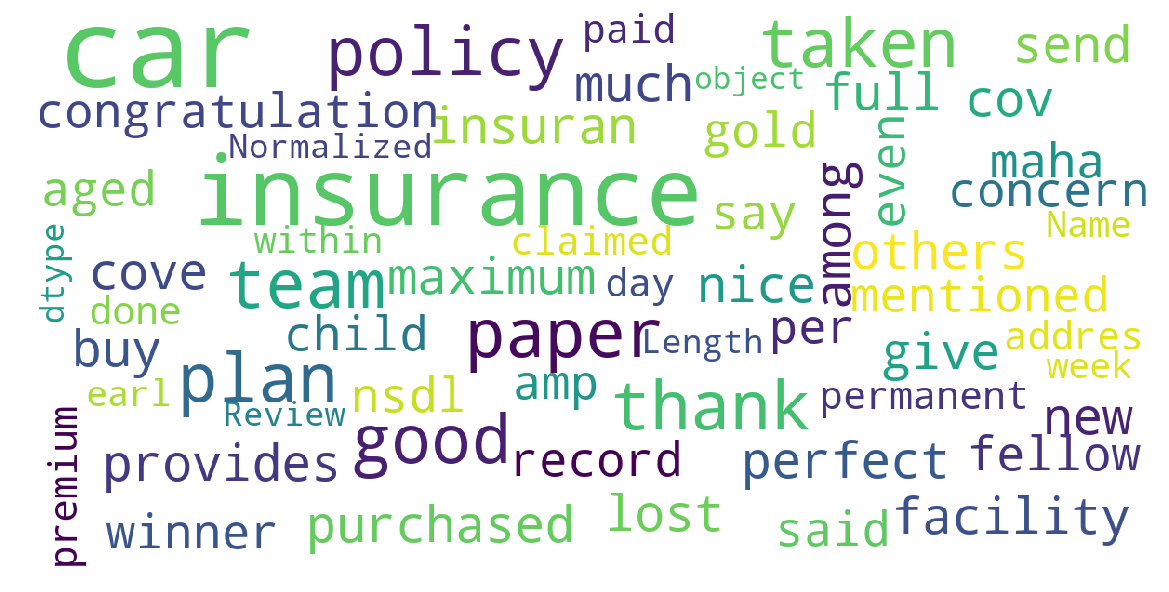

In [67]:
# print complete wordcloud
show_wordcloud(rated_dataset['Normalized Review'])

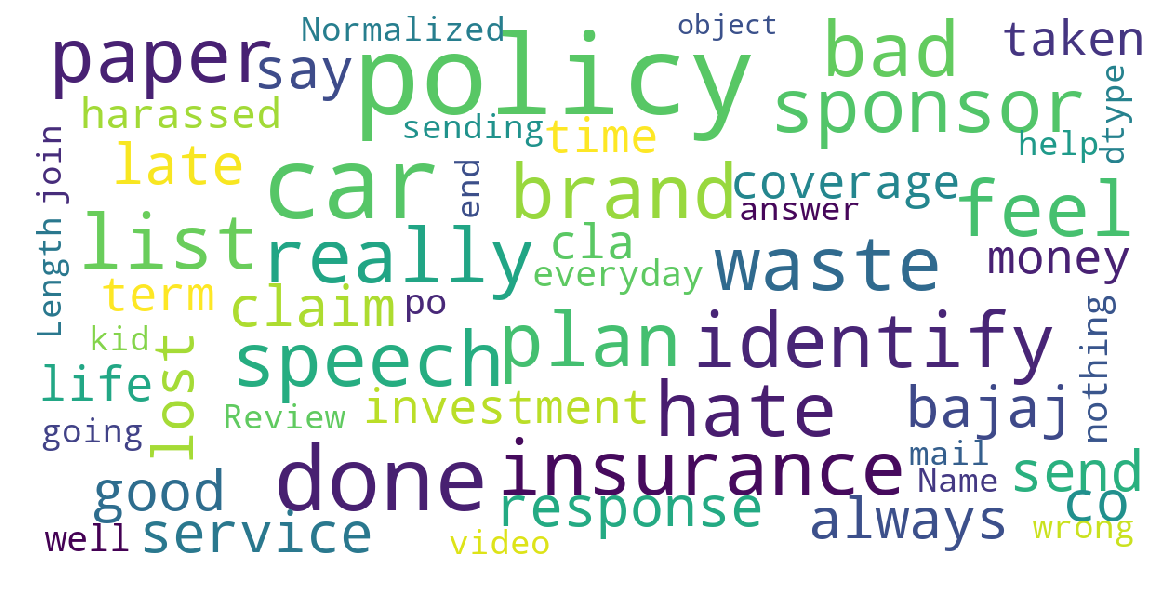

In [68]:
# Extract Negative Reviews for analysis 
negative_reviews_dataset = rated_dataset.loc[rated_dataset['Sentiment Code'] == 1]
# Print Wordcloud
show_wordcloud(negative_reviews_dataset['Normalized Review'])

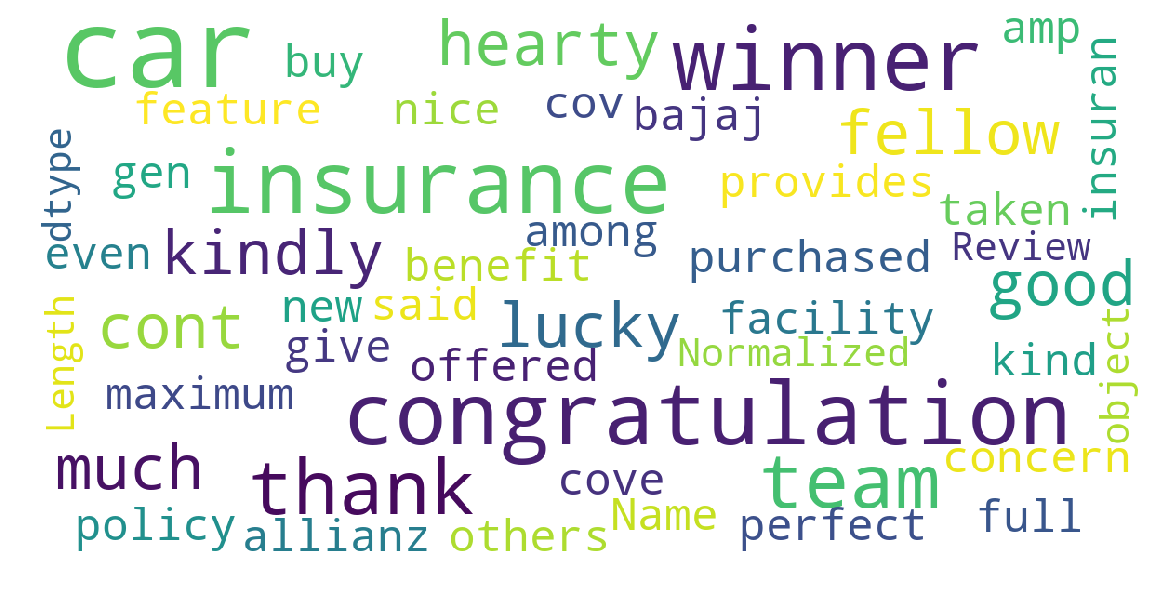

In [70]:
# Extract Positive Reviews for analysis 
positive_reviews_dataset = rated_dataset.loc[rated_dataset['Sentiment Code'] == 3]
# Print Wordcloud
show_wordcloud(positive_reviews_dataset['Normalized Review'])

In [73]:
# Define an empty dataframe to store the results of word analysis 
word_analysis_columns = ['Company','Negative Word','Neutral Word', 'Positive Word','Review']
word_analysis_df = pd.DataFrame(columns = word_analysis_columns)
# Loop through each review, calculate polarity based on Vader and store it along with comment in to the above defined dataframe
#for index, row in islice(negative_reviews_dataset.iterrows(), 0, None):
for index, row in islice(rated_dataset.iterrows(), 0, None):
    new_row = []
    company = str(row['Company'])  
    review = str(row['Normalized Review'])  
    negative_word, neutral_word, positive_word = get_vader_word_score(review)
# Add a new record with for each comment + polarity
    new_row += [company, negative_word, neutral_word, positive_word, review]
    all_words_df = pd.DataFrame([new_row], columns = word_analysis_columns)
    word_analysis_df = word_analysis_df.append(all_words_df, ignore_index=True)
# Export the results as csv to local drive
word_analysis_df.to_csv('word_analysis_11_02.csv', index = False)

In [74]:
print(rated_dataset.shape)
print(word_analysis_df.shape)

(2027, 487)
(2027, 5)


In [76]:
# function to plot most frequent terms 
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  
  fdist = FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()),   
             'count':list(fdist.values())}) 
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms)      
  plt.figure(figsize=(20,5)) 
  ax = sns.barplot(data=d, x= "word", y = "count") 
  ax.set(ylabel = 'Count') 
  plt.show()

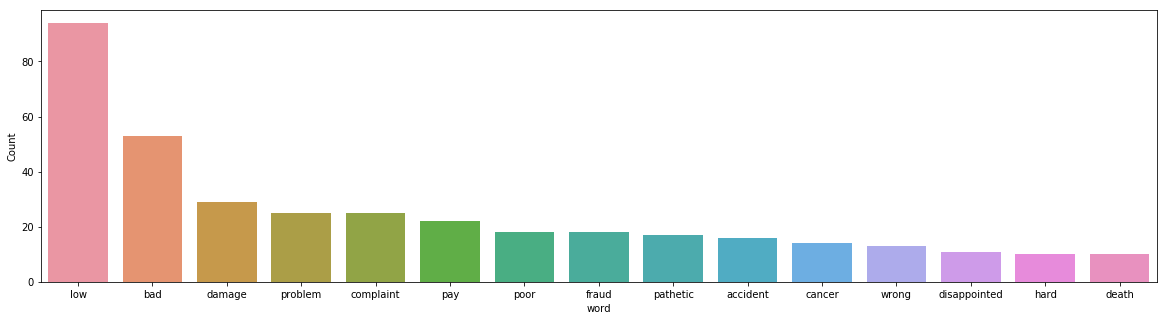

In [77]:
freq_words(word_analysis_df['Negative Word'], 15)

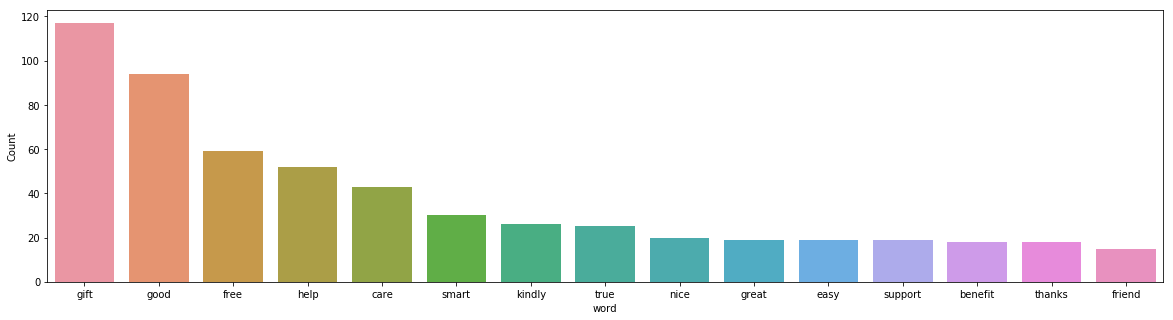

In [78]:
freq_words(word_analysis_df['Positive Word'], 15)

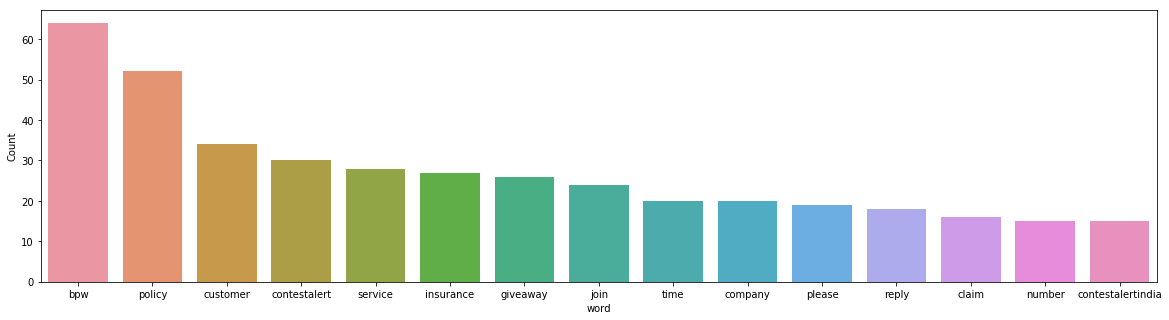

In [79]:
freq_words(word_analysis_df['Neutral Word'], 15)

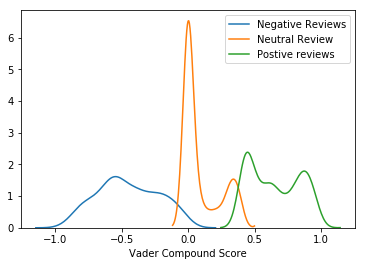

In [81]:
# plot sentiment distribution for positive and negative reviews

import seaborn as sns

for x in [1,2,3]:
    subset = rated_dataset[rated_dataset['Sentiment Code'] == x]
    
    # Draw the density plot
    if x == 1:
        label = 'Negative Reviews'
    elif x == 2:
        label = 'Neutral Review'
    else:
        label = 'Postive reviews'
    sns.distplot(subset['Vader Compound Score'], hist = False, label = label)

### Creating Model to detect bad reviews

In [82]:
rated_dataset.columns

Index(['Company', 'Review Date', 'Source', 'Tweet Source', 'User Location',
       'Vader Compound Score', 'Vader Negative Score', 'Vader Positive Score',
       'Vader Neutral Score', 'Number of Characters',
       ...
       'word_worst', 'word_would', 'word_wrong', 'word_year', 'word_years',
       'word_yes', 'word_yesterday', 'word_yet', 'word_you', 'word_your'],
      dtype='object', length=487)

In [90]:
# feature selection
label = 'Sentiment Code'
ignore_cols = [label,'Company', 'Review Date', 'Source', 'Tweet Source', 'User Location','Review', 'Review Clean', 
               'Normalized Review']
features = [c for c in rated_dataset.columns if c not in ignore_cols]

# split the data into train and test
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(rated_dataset[features], rated_dataset[label], test_size = 0.20, random_state = 5)

In [91]:
# train a random forest classifier
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(X_train, y_train)

# show feature importance
feature_importances_df = pd.DataFrame({"feature": features, "importance": rf.feature_importances_}).sort_values("importance", ascending = False)
feature_importances_df.head(20)

feature  importance
0    Vader Compound Score    0.252351
1    Vader Negative Score    0.139561
2    Vader Positive Score    0.131301
3     Vader Neutral Score    0.107989
4    Number of Characters    0.018863
5         Number of Words    0.015612
210        word_insurance    0.010287
437          word_unusual    0.008258
407              word_the    0.007858
175             word_gift    0.007785
9        doc2vec_vector_3    0.007769
82               word_car    0.007313
7        doc2vec_vector_1    0.007284
6        doc2vec_vector_0    0.007010
10       doc2vec_vector_4    0.006726
112         word_coverage    0.006293
67               word_box    0.005829
8        doc2vec_vector_2    0.005716
367          word_service    0.005692
468            word_worst    0.005304

In [ ]:
# ROC curve

#from sklearn.metrics import roc_curve, auc, roc_auc_score
#import matplotlib.pyplot as plt

#y_pred = [x[1] for x in rf.predict_proba(X_test)]
#fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)

#roc_auc = auc(fpr, tpr)

#plt.figure(1, figsize = (15, 10))
#lw = 2
#plt.plot(fpr, tpr, color='darkorange',
         #lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
#plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.0])
#plt.xlabel('False Positive Rate')
#plt.ylabel('True Positive Rate')
#plt.title('Receiver operating characteristic example')
#plt.legend(loc="lower right")
#plt.show()

In [ ]:
# PR curve

# # from sklearn.metrics import average_precision_score, precision_recall_curve
# #from sklearn.utils.fixes import signature
# from funcsigs import signature

# average_precision = average_precision_score(y_test, y_pred)

# precision, recall, _ = precision_recall_curve(y_test, y_pred)

# # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
# step_kwargs = ({'step': 'post'}
#                if 'step' in signature(plt.fill_between).parameters
#                else {})

# plt.figure(1, figsize = (15, 10))
# plt.step(recall, precision, color='b', alpha=0.2,
#          where='post')
# plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.ylim([0.0, 1.05])
# plt.xlim([0.0, 1.0])
# plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

In [92]:
# Predict test reviews
y_pred = rf.predict(X_test)

In [93]:
#X_test.columns

Index(['Vader Compound Score', 'Vader Negative Score', 'Vader Positive Score',
       'Vader Neutral Score', 'Number of Characters', 'Number of Words',
       'doc2vec_vector_0', 'doc2vec_vector_1', 'doc2vec_vector_2',
       'doc2vec_vector_3',
       ...
       'word_worst', 'word_would', 'word_wrong', 'word_year', 'word_years',
       'word_yes', 'word_yesterday', 'word_yet', 'word_you', 'word_your'],
      dtype='object', length=478)

In [98]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
#print("Precision:",metrics.precision_score(y_test, y_pred))
#print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.9926108374384236


In [95]:
# Make Confusion Matrix to compare results against actuals

from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test, y_pred)
cnf_matrix

array([[ 94,   0,   0],
       [  2, 168,   1],
       [  0,   0, 141]], dtype=int64)

In [96]:
# Save model as pmml file
from sklearn.externals import joblib 
# Save the model as a pickle in a file 
joblib.dump(rf, 'social_media_data_analysis_model.pkl') 


c:\users\tbhardwaj2\appdata\local\programs\python\python36\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['social_media_data_analysis_model.pkl']